***
# Data Collection: NCAA Men's March Madness
***

## Imports & Global Settings

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from Utils import *

In [216]:
pd.set_option('display.max_columns', None)
jimmer = 32 # Jimmer Fredette jersey number for randomizaion
duke = 1181 # TeamID for Duke to use for reference / debugging

***
## Data Wrangling & Preprocessing

**1) Load Raw Data** 
- Get team information (team names, conferences, etc.)
- Import data (`reg_results`, `tourney_results`, etc.)


**2) Restructure Data for Analysis**  
- Convert regular season results into team-level format
- Ensure each row represents a single team's performance in a game

**3) Game-level Statistics**  
- Compute additional game-level statistics not included in original dataset (before aggregation)

**4) Aggregation**  
- Aggregate stats for total season, wins only, losses only (e.g., FG%, WFG%, and LFG% to see if stats vary materially)
- Compute opponent stats for same granularity

**5) Advanced Metrics**
- Compute additional advanced metrics
- Incorporate precomputed advanced metrics (e.g., KenPom)

***

In [217]:
# Load in Team-level Info
teams = pd.read_csv('./Data/Mteams.csv', dtype={'TeamID': str}).set_index('TeamID')['TeamName']
conferences = pd.read_csv('./Data/MTeamConferences.csv', dtype={'TeamID': str})
conf_names = pd.read_csv('./Data/Conferences.csv')

In [218]:
display(teams.head())
display(conferences.head())
display(conf_names.head())

TeamID
1101    Abilene Chr
1102      Air Force
1103          Akron
1104        Alabama
1105    Alabama A&M
Name: TeamName, dtype: object

,Season,TeamID,ConfAbbrev
0,1985,1102,wac
1,1985,1103,ovc
2,1985,1104,sec
3,1985,1106,swac
4,1985,1108,swac


,ConfAbbrev,Description
0,a_sun,Atlantic Sun Conference
1,a_ten,Atlantic 10 Conference
2,aac,American Athletic Conference
3,acc,Atlantic Coast Conference
4,aec,America East Conference


In [219]:
# Shapes of original data
print(teams.shape)
print(conferences.shape)
print(conf_names.shape)

# Check Nulls
print(teams.isna().sum().sum())
print(conferences.isna().sum().sum())
print(conf_names.isna().sum().sum())

# Check dupes
print(teams.duplicated().sum().sum())
print(conferences.duplicated().sum().sum())
print(conf_names.duplicated().sum().sum())

(380,)
(13388, 3)
(51, 2)
0
0
0
0
0
0


In [220]:
# Merge Team and conference info
conferences['TeamName'] = conferences['TeamID'].map(teams)
team_info = conferences.merge(conf_names, on='ConfAbbrev')
team_info['ConfAbbrev'] = team_info['ConfAbbrev'].str.upper()

The large number of records in the `conferences` dataset is likely due to frequent conference realignments over time.

In recent years, several major college programs have switched conferences, primarily driven by financial incentives, competitive opportunities, and long-term stability. Below is a list of some recent, notable conference moves.

| Year | School Name                               | New Conference | Previous Conference |
|------|-------------------------------------------|----------------|---------------------|
| 2011 | University of Nebraska                    | Big Ten        | Big 12              |
| 2012 | Texas A&M University                      | SEC            | Big 12              |
| 2012 | University of Missouri                    | SEC            | Big 12              |
| 2013 | University of Pittsburgh                  | ACC            | Big East            |
| 2013 | Syracuse University                       | ACC            | Big East            |
| 2014 | University of Louisville                  | ACC            | American Athletic   |
| 2014 | University of Maryland                    | Big Ten        | ACC                 |
| 2024 | University of California, Los Angeles     | Big Ten        | Pac-12              |
| 2024 | University of Southern California         | Big Ten        | Pac-12              |
| 2024 | University of Oregon                      | Big Ten        | Pac-12              |
| 2024 | University of Washington                  | Big Ten        | Pac-12              |
| 2024 | University of Arizona                     | Big 12         | Pac-12              |
| 2024 | Arizona State University                  | Big 12         | Pac-12              |
| 2024 | University of Colorado                    | Big 12         | Pac-12              |
| 2024 | University of Utah                        | Big 12         | Pac-12              |
| 2024 | University of California, Berkeley        | ACC            | Pac-12              |
| 2024 | Stanford University                       | ACC            | Pac-12              |


The large exodus of teams from the `Pac-12` in 2024 was due to the conference's inability to secure a competitive media rights deal, while other conferences (Big Ten, SEC, Big 12) locked in lucrative TV contracts with networks like ESPN, Fox, and CBS.

In [221]:
# Example team and conference movement for Stanford
school = 'Stanford'
school_conferences = team_info[team_info['TeamName'] == school]['ConfAbbrev'].unique()
print(f"{school}: {school_conferences}")

Stanford: ['PAC_TEN' 'PAC_TWELVE' 'ACC']


In [222]:
display(team_info.head())
print(team_info.shape)
print(team_info.isna().sum().sum())

,Season,TeamID,ConfAbbrev,TeamName,Description
0,1985,1102,WAC,Air Force,Western Athletic Conference
1,1985,1103,OVC,Akron,Ohio Valley Conference
2,1985,1104,SEC,Alabama,Southeastern Conference
3,1985,1106,SWAC,Alabama St,Southwest Athletic Conference
4,1985,1108,SWAC,Alcorn St,Southwest Athletic Conference


(13388, 5)
0


In [223]:
# Reorder columns
team_info = team_info[['Season', 'TeamID', 'TeamName','ConfAbbrev','Description']]
team_info.nunique()

Season          41
TeamID         380
TeamName       380
ConfAbbrev      51
Description     51
dtype: int64

In [224]:
max_season = team_info['Season'].max()
min_season = team_info['Season'].min()

print(f"The dataset contains historical data for {team_info['Season'].nunique()} seasons ({min_season} - {max_season}).")
print(f"It includes information on {team_info['TeamID'].nunique()} unique teams across {team_info['ConfAbbrev'].nunique()} historical conferences.")

The dataset contains historical data for 41 seasons (1985 - 2025).
It includes information on 380 unique teams across 51 historical conferences.


***
## Regular Season Results

**Load Historical Regular Season Data**

The below dataset represents detailed, game-level box scores for the **regular season** where:
- `WTeamID` and `LTeamID` represent the teams that won and lost each game, respectively.
- Team statistics are prefixed with **"W"** for the winning team and **"L"** for the losing team.
***

In [225]:
# Historical Regular Season Results
reg_results = pd.read_csv('./Data/MRegularSeasonDetailedResults.csv', dtype={
        'WTeamID': str,
        'LTeamID': str})

In [226]:
max_season = reg_results['Season'].max()
min_season = reg_results['Season'].min()

print(f"The Regular Season dataset contains historical data for {reg_results['Season'].nunique()} seasons ({max_season} - {min_season}).")

The Regular Season dataset contains historical data for 23 seasons (2025 - 2003).


In [227]:
# Historical game-level box scores
print(f"Shape of Regular Season Results: {reg_results.shape}")
display(reg_results.head())

Shape of Regular Season Results: (118882, 34)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [228]:
# Add Team names to season results
reg_results['WTeamName'] = reg_results['WTeamID'].map(teams)
reg_results['LTeamName'] = reg_results['LTeamID'].map(teams)

# Add Losing Location to season results and tournament results (Opposite of WLoc)
reg_results['LLoc'] = reg_results['WLoc'].map({'H': 'A', 'A': 'H', 'N': 'N'})

In [229]:
# Quickly reorder columns
reorder = ['Season', 'DayNum', 'WTeamID', 'WTeamName', 'LTeamID', 'LTeamName', 'WScore', 'LScore', 'WLoc', 'LLoc',  'NumOT']
reg_results = reg_results[reorder + [col for col in reg_results.columns if col not in reorder]]

display(reg_results.head())

,Season,DayNum,WTeamID,WTeamName,LTeamID,LTeamName,WScore,LScore,WLoc,LLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,Alabama,1328,Oklahoma,68,62,N,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,Memphis,1393,Syracuse,70,63,N,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,Marquette,1437,Villanova,73,61,N,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,N Illinois,1457,Winthrop,56,50,N,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,Texas,1208,Georgia,77,71,N,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


### Restructure Data for Analysis

Currently, each row in the dataset represents a single game with two teams:
- Winning Team (`WTeamID`), with stats prefixed by `"W"` (e.g., `WFGM`, `WFGA`, `WTO`)
- Losing Team (`LTeamID`), with stats prefixed by `"L"` (e.g., `LFGM`, `LFGA`, `LTO`)

This structure makes it difficult to analyze teams independently because:
- A team's stats are split across two columns—sometimes under `"W"` and sometimes under `"L"`
- To compute season-level stats for a team, we would need to pull its games from both `WTeamID` and `LTeamID` and merge them
- There is no single `TeamID` column that consolidates all of a team's stats, making it impossible to group by `TeamID` alone

***

#### Winning & Losing Dataframe Approach
To fix this, separate **'winning'** and **'losing'** dataframes are created for the regular season results (`reg_results`).

- To create the 'winning' df, the **winning team** (`WTeamID`) is updated to `TeamID` and the losing team's stats are assigned as opponent stats (`OppFGM`, `OppFGA`, etc.)
- To create the 'losing df, the **losing team** (`LTeamID`) is updated to `TeamID` and the winning team's stats are assigned as opponent stats (`OppFGM`, `OppFGA`, etc.)
- The "W" and "L" prefixes are removed from both datasets to ensure that every row shares the same stat names (`FGM`, `FGA`, `TO`, `OppFGM` etc.)
- The dataframes are then merged into a **combined dataframe** where each row represents an individual team's game performance their opponent's statistics (regardless of W or L)

This transformation allows us to easily compute per-game, per-season, and opponent stats, which will be highly beneficial for feature engineering and modeling.
***

#### Create winning and losing dfs for the regular season results (`reg_results`)

In [230]:
reg_results.head()

,Season,DayNum,WTeamID,WTeamName,LTeamID,LTeamName,WScore,LScore,WLoc,LLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,Alabama,1328,Oklahoma,68,62,N,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,Memphis,1393,Syracuse,70,63,N,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,Marquette,1437,Villanova,73,61,N,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,N Illinois,1457,Winthrop,56,50,N,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,Texas,1208,Georgia,77,71,N,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [231]:
non_WL_cols = [col for col in reg_results.columns if col[0] != 'W' and col[0] != 'L']
print(f"Game-level information columns (not winning or losing specific features): {non_WL_cols}")

Game-level information columns (not winning or losing specific features): ['Season', 'DayNum', 'NumOT']


In [232]:
def restructure_data(df):
    df_copy = df.copy()
    
    # Make losing columns Opponent columns and remove prefix
    winning = df_copy.rename(columns=lambda x: f"Opp{x[1:]}" if x.startswith("L") else x)
    winning = winning.rename(columns=lambda x: x[1:] if x.startswith("W") else x)

    # Assign GameResult and Win columns
    winning["GameResult"] = 'W'
    winning["Win"] = 1

    # Make winning columns Opponent columns and remove prefix
    lossing = df_copy.rename(columns=lambda x: f"Opp{x[1:]}" if x.startswith("W") else x)
    lossing = lossing.rename(columns=lambda x: x[1:] if x.startswith("L") else x)

    # Assign GameResult and Win columns
    lossing["GameResult"] = 'L'
    lossing["Win"] = 0

    combined_df = pd.concat([winning, lossing], ignore_index=True)

    return combined_df

In [233]:
reg_combined_df = restructure_data(reg_results)

# There are 2 records for each game in the reg_combined_df, so the number of rows in the combined dataframe should be exactly double the original dataframe
assert len(reg_combined_df) == 2 * len(reg_results)

print(f"Missing Values: {reg_combined_df.isna().sum().sum()}")
print(f"Duplicate Values: {reg_combined_df.duplicated().sum().sum()}")
print(f"Shape:{reg_combined_df.shape}")
display(reg_combined_df)

Missing Values: 0
Duplicate Values: 0
Shape:(237764, 39)


,Season,DayNum,TeamID,TeamName,OppTeamID,OppTeamName,Score,OppScore,Loc,OppLoc,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,OppFGM,OppFGA,OppFGM3,OppFGA3,OppFTM,OppFTA,OppOR,OppDR,OppAst,OppTO,OppStl,OppBlk,OppPF,GameResult,Win
0,2003,10,1104,Alabama,1328,Oklahoma,68,62,N,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,W,1
1,2003,10,1272,Memphis,1393,Syracuse,70,63,N,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,W,1
2,2003,11,1266,Marquette,1437,Villanova,73,61,N,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,W,1
3,2003,11,1296,N Illinois,1457,Winthrop,56,50,N,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,W,1
4,2003,11,1400,Texas,1208,Georgia,77,71,N,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,W,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237759,2025,132,1397,Tennessee,1196,Florida,77,86,N,N,0,22,49,8,26,25,32,5,20,15,9,7,5,21,26,61,9,27,25,28,15,24,11,8,6,1,25,L,0
237760,2025,132,1412,UAB,1272,Memphis,72,84,N,N,0,24,69,7,27,17,23,21,23,10,15,5,4,21,32,68,6,13,14,23,18,27,13,12,10,7,18,L,0
237761,2025,132,1458,Wisconsin,1276,Michigan,53,59,N,N,0,15,68,7,39,16,18,15,31,8,6,3,2,14,19,59,9,33,12,13,6,34,14,8,3,2,16,L,0
237762,2025,132,1206,George Mason,1433,VCU,63,68,N,N,0,19,56,9,21,16,19,14,19,13,11,11,3,22,19,47,8,25,22,27,11,25,10,16,7,9,20,L,0


***
## Game-level Statistics

- Create addtional game-level detail for more granularity and feature engineering opportunities
- Game-level information is added before any season-level aggregation is performed 
***

In [234]:
stat_dict = {
        'FG_Percentage': ('FGM', 'FGA'),
        'FG3_Percentage': ('FGM3', 'FGA3'),
        'FT_Percentage': ('FTM', 'FTA'),
        'Ast_TO_Ratio': ('Ast', 'TO')
    }


diff_stats = [
    'Score','FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA',
    'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF',

    # Advanced stats - Can add more diff_stats here as we consider additional advanced game-level stats
    'Poss', 'OffEff', 'DefEff'
]


In [235]:
def compute_game_features(df):
    """
    Computes per-game efficiency stats, possession-based metrics, difference features,
    and inverse opponent features to support modeling.
    """

    # Efficiency Stats (FG%, 3P%, FT%, Ast/TO)
    for new_col, (num, den) in stat_dict.items():
        df = create_percentage_col(df, num, den, new_col)
    for new_col, (num, den) in stat_dict.items():
        df = create_percentage_col(df, f"Opp{num}", f"Opp{den}", f"Opp{new_col}")

    # Possessions
    df["Poss"] = df["FGA"] - df["OR"] + df["TO"] + (0.475 * df["FTA"])
    df["OppPoss"] = df["OppFGA"] - df["OppOR"] + df["OppTO"] + (0.475 * df["OppFTA"])

    # Efficiency Ratings
    df["OffEff"] = df["Score"] / df["Poss"]
    df["DefEff"] = df["OppScore"] / df["OppPoss"]
    df["OppOffEff"] = df["DefEff"]
    df["OppDefEff"] = df["OffEff"]

    # Difference-Based Features
    for stat in diff_stats:
        df = create_difference_col(df, stat, f"Opp{stat}", f"{stat}_Diff")

    diff_cols = [col for col in reg_combined_df.columns if col.endswith('_Diff')]
    
    # Percentage-Based Differences
    for col in diff_cols:
        opp_col = col.replace("_Diff", "")
        new_col = f"{col}_Pct"
        df = create_percentage_col(df, col, f"Opp{opp_col}", new_col)

    # Opponent Difference Columns as Negatives (without duplicates)
    opp_diff_dict = {
        f"{col}_Opp": -df[col]
        for col in df.columns
        if (col.endswith("_Diff") or col.endswith("_Diff_Pct")) and f"{col}_Opp" not in df.columns
    }

    # Concatenate new opponent diff columns
    df = pd.concat([df, pd.DataFrame(opp_diff_dict, index=df.index)], axis=1)

    return df

In [236]:
reg_combined_df = compute_game_features(reg_combined_df)

In [237]:
print('Regular Season Combined DataFrame:')
print(f"Shape: {reg_combined_df.shape}")
print(f"Missing values: {reg_combined_df.isna().sum().sum()}")
display(reg_combined_df.head())

Regular Season Combined DataFrame:
Shape: (237764, 121)
Missing values: 0


,Season,DayNum,TeamID,TeamName,OppTeamID,OppTeamName,Score,OppScore,Loc,OppLoc,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,OppFGM,OppFGA,OppFGM3,OppFGA3,OppFTM,OppFTA,OppOR,OppDR,OppAst,OppTO,OppStl,OppBlk,OppPF,GameResult,Win,FG_Percentage,FG3_Percentage,FT_Percentage,Ast_TO_Ratio,OppFG_Percentage,OppFG3_Percentage,OppFT_Percentage,OppAst_TO_Ratio,Poss,OppPoss,OffEff,DefEff,OppOffEff,OppDefEff,Score_Diff,FGM_Diff,FGA_Diff,FGM3_Diff,FGA3_Diff,FTM_Diff,FTA_Diff,OR_Diff,DR_Diff,Ast_Diff,TO_Diff,Stl_Diff,Blk_Diff,PF_Diff,Poss_Diff,OffEff_Diff,DefEff_Diff,Score_Diff_Pct,FGM_Diff_Pct,FGA_Diff_Pct,FGM3_Diff_Pct,FGA3_Diff_Pct,FTM_Diff_Pct,FTA_Diff_Pct,OR_Diff_Pct,DR_Diff_Pct,Ast_Diff_Pct,TO_Diff_Pct,Stl_Diff_Pct,Blk_Diff_Pct,PF_Diff_Pct,Poss_Diff_Pct,OffEff_Diff_Pct,DefEff_Diff_Pct,Score_Diff_Opp,FGM_Diff_Opp,FGA_Diff_Opp,FGM3_Diff_Opp,FGA3_Diff_Opp,FTM_Diff_Opp,FTA_Diff_Opp,OR_Diff_Opp,DR_Diff_Opp,Ast_Diff_Opp,TO_Diff_Opp,Stl_Diff_Opp,Blk_Diff_Opp,PF_Diff_Opp,Poss_Diff_Opp,OffEff_Diff_Opp,DefEff_Diff_Opp,Score_Diff_Pct_Opp,FGM_Diff_Pct_Opp,FGA_Diff_Pct_Opp,FGM3_Diff_Pct_Opp,FGA3_Diff_Pct_Opp,FTM_Diff_Pct_Opp,FTA_Diff_Pct_Opp,OR_Diff_Pct_Opp,DR_Diff_Pct_Opp,Ast_Diff_Pct_Opp,TO_Diff_Pct_Opp,Stl_Diff_Pct_Opp,Blk_Diff_Pct_Opp,PF_Diff_Pct_Opp,Poss_Diff_Pct_Opp,OffEff_Diff_Pct_Opp,DefEff_Diff_Pct_Opp
0,2003,10,1104,Alabama,1328,Oklahoma,68,62,N,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,W,1,0.465517,0.214286,0.611111,0.565217,0.415094,0.200000,0.727273,0.444444,75.550,71.450,0.900066,0.867740,0.867740,0.900066,6,5,5,1,4,-5,-4,4,2,5,5,-2,-1,2,4.100,0.032327,-0.032327,0.096774,0.227273,0.094340,0.500000,0.400000,-0.312500,-0.181818,0.400000,0.090909,0.625000,0.277778,-0.222222,-0.500000,0.100000,0.057383,0.037254,-0.035916,-6,-5,-5,-1,-4,5,4,-4,-2,-5,-5,2,1,-2,-4.100,-0.032327,0.032327,-0.096774,-0.227273,-0.094340,-0.500000,-0.400000,0.312500,0.181818,-0.400000,-0.090909,-0.625000,-0.277778,0.222222,0.500000,-0.100000,-0.057383,-0.037254,0.035916
1,2003,10,1272,Memphis,1393,Syracuse,70,63,N,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,W,1,0.419355,0.400000,0.526316,1.230769,0.358209,0.250000,0.450000,0.583333,69.025,68.500,1.014125,0.919708,0.919708,1.014125,7,2,-5,2,-4,1,-1,-5,3,9,1,-4,-2,2,0.525,0.094417,-0.094417,0.111111,0.083333,-0.074627,0.333333,-0.166667,0.111111,-0.050000,-0.250000,0.120000,1.285714,0.083333,-0.500000,-0.333333,0.125000,0.007664,0.102660,-0.093102,-7,-2,5,-2,4,-1,1,5,-3,-9,-1,4,2,-2,-0.525,-0.094417,0.094417,-0.111111,-0.083333,0.074627,-0.333333,0.166667,-0.111111,0.050000,0.250000,-0.120000,-1.285714,-0.083333,0.500000,0.333333,-0.125000,-0.007664,-0.102660,0.093102
2,2003,11,1266,Marquette,1437,Villanova,73,61,N,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,W,1,0.413793,0.444444,0.586207,1.500000,0.301370,0.115385,0.608696,0.750000,64.775,64.925,1.126978,0.939546,0.939546,1.126978,12,2,-15,5,-8,3,6,-14,4,6,-2,3,-3,2,-0.150,0.187432,-0.187432,0.196721,0.090909,-0.205479,1.666667,-0.307692,0.214286,0.260870,-0.451613,0.181818,0.666667,-0.166667,1.500000,-0.600000,0.086957,-0.002310,0.199493,-0.166314,-12,-2,15,-5,8,-3,-6,14,-4,-6,2,-3,3,-2,0.150,-0.187432,0.187432,-0.196721,-0.090909,0.205479,-1.666667,0.307692,-0.214286,-0.260870,0.451613,-0.181818,-0.666667,0.166667,-1.500000,0.600000,-0.086957,0.002310,-0.199493,0.166314
3,2003,11,1296,N Illinois,1457,Winthrop,56,50,N,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,W,1,0.473684,0.333333,0.548387,0.916667,0.367347,0.272727,0.533333,0.473684,58.725,58.125,0.953597,0.860215,0.860215,0.953597,6,0,-11,-3,-13,9,16,-11,-1,2,-7,10,-1,-5,0.600,0.093382,-0.093382,0.120000,0.000000,-0.224490,-0.500000,-0.590909,1.125000,1.066667,-0.647059,-0.050000,0.222222,-0.368421,2.500000,-0.333333,-0.217391,0.010323,0.108557,-0.097926,-6,0,11,3,13,-9,-16,11,1,-2,7,-10,1,5,-0.600,-0.093382,0.093382,-0.120000,-0.000000,0.224490,0.500000,0.590909,-1.125000,-1.0

***
## Massey Ordinals

Compiled by Kenneth Massey, the **Massey Ordinals** represent an ensemble of independently derived team ranking systems, each grounded in distinct statistical methodologies — from margin-of-victory models to predictive power ratings and tempo-free efficiency metrics. These ordinal rankings provide  a diverse set of quantitative perspectives on team strength and quality.

**KenPom:** Created by Ken Pomeroy, KenPom is one of the most widely respected college basketball analytics systems. It uses tempo-free statistics to evaluate team performance, emphasizing efficiency on both offense and defense while adjusting for strength of schedule. 
***

In [238]:
ordinals_df = pd.read_csv('./Data/MMasseyOrdinals.csv', dtype={'TeamID': str})

In [239]:
ordinals_df.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


In [257]:
kenpom = ordinals_df[ordinals_df['SystemName'] == 'POM'].rename(columns={'RankingDayNum': 'DayNum', 'OrdinalRank': 'KenPomRank'})
kenpom = kenpom.drop(columns='SystemName')
kenpom

,Season,DayNum,TeamID,KenPomRank
2968,2003,37,1102,104
2969,2003,37,1103,191
2970,2003,37,1104,15
2971,2003,37,1105,319
2972,2003,37,1106,170
...,...,...,...,...
5560304,2025,133,1476,322
5560305,2025,133,1477,330
5560306,2025,133,1478,354
5560307,2025,133,1479,342


To efficiently align KenPom ratings with each game, we construct a complete grid of every `TeamID`, `Season`, and `DayNum` in the schedule. Since KenPom updates are only available weekly, we forward-fill each team’s rating across all days to ensure that every game can be matched with the most recent available rating.

In [241]:
# Create a full grid of Season, TeamID, and DayNum (0–133)
all_days = pd.DataFrame({'DayNum': range(134)})
teams_seasons = kenpom[['Season', 'TeamID']].drop_duplicates()
full_grid = teams_seasons.merge(all_days, how='cross')

# Merge in known KenPom values
full_kenpom = full_grid.merge(kenpom, on=['Season', 'TeamID', 'DayNum'], how='left')

# Step 4: Forward-fill KenPomRank by Season and TeamID
full_kenpom = full_kenpom.sort_values(['Season', 'TeamID', 'DayNum'])

full_kenpom['KenPomRank'] = (
    full_kenpom
    .groupby(['Season', 'TeamID'])['KenPomRank']
    .transform(lambda x: x.ffill().bfill())
)

In [242]:
# Merge KenPom rankings for TeamID
reg_combined_df = reg_combined_df.merge(
    full_kenpom,
    on=['Season', 'TeamID', 'DayNum'],
    how='left'
)

# Merge KenPom rankings for OppTeamID
full_kenpom_opp = full_kenpom.rename(columns={'TeamID': 'OppTeamID', 'KenPomRank': 'OppKenPomRank'})
reg_combined_df = reg_combined_df.merge(
    full_kenpom_opp,
    on=['Season', 'OppTeamID', 'DayNum'],
    how='left'
)

In [243]:
# reg_combined_df['KenPomDiff'] = reg_combined_df['KenPomRank'] - reg_combined_df['OppKenPomRank']
# reg_combined_df['OppKenPomDiff'] = -reg_combined_df['KenPomDiff']

In [244]:
display(reg_combined_df[reg_combined_df.isna().any(axis=1)]['Season'].value_counts())
display(reg_combined_df[reg_combined_df['KenPomRank'].isna()][['TeamName', 'TeamID']].value_counts())

Season
2009    80
2008    20
Name: count, dtype: int64

TeamName      TeamID
Seattle       1370      21
North Dakota  1315      15
South Dakota  1377      12
Houston Chr   1223      10
Name: count, dtype: int64

In [245]:
percent_affected = len(reg_combined_df[reg_combined_df.isna().any(axis=1)]) / len(reg_combined_df) * 100
print(f"The percent of rows affected by missing KenPom values: {percent_affected:.2f}%")

The percent of rows affected by missing KenPom values: 0.04%


In [246]:
seasons = [2008, 2009]

for season in seasons:
    max_kenpom = reg_combined_df.loc[reg_combined_df['Season'] == season]['KenPomRank'].max()

    # Fill all missing KenPomRank values  with max + 1
    reg_combined_df.loc[
        (reg_combined_df['Season'] == season) & (reg_combined_df['KenPomRank'].isna()),
        'KenPomRank'
    ] = max_kenpom + 1

    reg_combined_df.loc[
    (reg_combined_df['Season'] == season) & (reg_combined_df['OppKenPomRank'].isna()),
    'OppKenPomRank'
] = max_kenpom + 1

# Create KenPom difference columns
reg_combined_df['KenPomDiff'] = reg_combined_df['KenPomRank'] - reg_combined_df['OppKenPomRank']
reg_combined_df['OppKenPomDiff'] = -reg_combined_df['KenPomDiff']

In [247]:
reg_combined_df.isna().sum().sum()

np.int64(0)

***
### Missing KenPom Data for Select Schools (2008–2009)

The following schools are missing from the KenPom ratings dataset during the 2008–2009 seasons:

- Seattle University (TeamID: 1370)
- University of North Dakota (TeamID: 1315)
- University of South Dakota (TeamID: 1377)
- Houston Christian University (formerly Houston Baptist, TeamID: 1223)

After further research, the missing values can be attributed to these programs either actively transitioning to NCAA Division I or having recently joined but not yet being eligible for inclusion in KenPom's ratings.

To ensure these teams are included in modeling without introducing NaNs, we impute their missing `KenPomRank` by assigning them the maximum KenPom rating for that corresponding season plus 1, effectively treating them as the lowest-ranked teams in the system. 
***

***
## Aggregation Statistics
***

In [248]:
numeric_cols = reg_combined_df.select_dtypes(include=["number"]).columns.tolist()
exclude = ['Season', 'DayNum']
numeric_cols = [col for col in numeric_cols if col not in exclude]

In [249]:
def compute_aggregates(df):
    """
    Aggregates stats at the season level.
    - Computes total stats (all games)
    - Computes stats for wins/losses separately
    - Computes opponent aggregate stats
    """
    
    # Total season averages (all games)
    total_stats = df.groupby(["Season", "TeamID"])[numeric_cols].mean().reset_index()
    total_stats = total_stats.rename(columns=lambda x: f"{x}_PerGame" if x not in ["Season", "TeamID"] else x)

    # Winning game averages
    win_stats = df[df["Win"] == 1].groupby(["Season", "TeamID"])[numeric_cols].mean().reset_index()
    win_stats = win_stats.rename(columns=lambda x: f"{x}_PerWin" if x not in ["Season", "TeamID"] else x)

    # Losing game averages
    loss_stats = df[df["Win"] == 0].groupby(["Season", "TeamID"])[numeric_cols].mean().reset_index()
    loss_stats = loss_stats.rename(columns=lambda x: f"{x}_PerLoss" if x not in ["Season", "TeamID"] else x)

    # Total Games Played (count occurrences of TeamID)
    total_games = df.groupby(["Season", "TeamID"]).size().reset_index(name="TotalGames")
    total_wins = df.groupby(["Season", "TeamID"])["Win"].sum().reset_index().rename(columns={"Win": "TotalWins"})
    summary_stats = total_games.merge(total_wins, on=["Season", "TeamID"])
    summary_stats["TotalLosses"] = summary_stats["TotalGames"] - summary_stats["TotalWins"]
    summary_stats["WinningPercentage"] = summary_stats["TotalWins"] / summary_stats["TotalGames"]

    team_season_stats = (
        summary_stats
        .merge(total_stats, on=["Season", "TeamID"], how="left")
        .merge(win_stats, on=["Season", "TeamID"], how="left")
        .merge(loss_stats, on=["Season", "TeamID"], how="left")

    )

    # Fill missing values with 0 for teams that had 0 wins or 0 losses
    team_season_stats = team_season_stats.fillna(0)

    return team_season_stats

In [250]:
# Compute aggregatations
reg_team_stats = compute_aggregates(reg_combined_df)

In [251]:
print(reg_team_stats.shape)
print(f"Missing values: {reg_team_stats.isna().sum().sum()}")
display(reg_team_stats.head())

(7981, 354)
Missing values: 0


,Season,TeamID,TotalGames,TotalWins,TotalLosses,WinningPercentage,Score_PerGame,OppScore_PerGame,NumOT_PerGame,FGM_PerGame,FGA_PerGame,FGM3_PerGame,FGA3_PerGame,FTM_PerGame,FTA_PerGame,OR_PerGame,DR_PerGame,Ast_PerGame,TO_PerGame,Stl_PerGame,Blk_PerGame,PF_PerGame,OppFGM_PerGame,OppFGA_PerGame,OppFGM3_PerGame,OppFGA3_PerGame,OppFTM_PerGame,OppFTA_PerGame,OppOR_PerGame,OppDR_PerGame,OppAst_PerGame,OppTO_PerGame,OppStl_PerGame,OppBlk_PerGame,OppPF_PerGame,Win_PerGame,FG_Percentage_PerGame,FG3_Percentage_PerGame,FT_Percentage_PerGame,Ast_TO_Ratio_PerGame,OppFG_Percentage_PerGame,OppFG3_Percentage_PerGame,OppFT_Percentage_PerGame,OppAst_TO_Ratio_PerGame,Poss_PerGame,OppPoss_PerGame,OffEff_PerGame,DefEff_PerGame,OppOffEff_PerGame,OppDefEff_PerGame,Score_Diff_PerGame,FGM_Diff_PerGame,FGA_Diff_PerGame,FGM3_Diff_PerGame,FGA3_Diff_PerGame,FTM_Diff_PerGame,FTA_Diff_PerGame,OR_Diff_PerGame,DR_Diff_PerGame,Ast_Diff_PerGame,TO_Diff_PerGame,Stl_Diff_PerGame,Blk_Diff_PerGame,PF_Diff_PerGame,Poss_Diff_PerGame,OffEff_Diff_PerGame,DefEff_Diff_PerGame,Score_Diff_Pct_PerGame,FGM_Diff_Pct_PerGame,FGA_Diff_Pct_PerGame,FGM3_Diff_Pct_PerGame,FGA3_Diff_Pct_PerGame,FTM_Diff_Pct_PerGame,FTA_Diff_Pct_PerGame,OR_Diff_Pct_PerGame,DR_Diff_Pct_PerGame,Ast_Diff_Pct_PerGame,TO_Diff_Pct_PerGame,Stl_Diff_Pct_PerGame,Blk_Diff_Pct_PerGame,PF_Diff_Pct_PerGame,Poss_Diff_Pct_PerGame,OffEff_Diff_Pct_PerGame,DefEff_Diff_Pct_PerGame,Score_Diff_Opp_PerGame,FGM_Diff_Opp_PerGame,FGA_Diff_Opp_PerGame,FGM3_Diff_Opp_PerGame,FGA3_Diff_Opp_PerGame,FTM_Diff_Opp_PerGame,FTA_Diff_Opp_PerGame,OR_Diff_Opp_PerGame,DR_Diff_Opp_PerGame,Ast_Diff_Opp_PerGame,TO_Diff_Opp_PerGame,Stl_Diff_Opp_PerGame,Blk_Diff_Opp_PerGame,PF_Diff_Opp_PerGame,Poss_Diff_Opp_PerGame,OffEff_Diff_Opp_PerGame,DefEff_Diff_Opp_PerGame,Score_Diff_Pct_Opp_PerGame,FGM_Diff_Pct_Opp_PerGame,FGA_Diff_Pct_Opp_PerGame,FGM3_Diff_Pct_Opp_PerGame,FGA3_Diff_Pct_Opp_PerGame,FTM_Diff_Pct_Opp_PerGame,FTA_Diff_Pct_Opp_PerGame,OR_Diff_Pct_Opp_PerGame,DR_Diff_Pct_Opp_PerGame,Ast_Diff_Pct_Opp_PerGame,TO_Diff_Pct_Opp_PerGame,Stl_Diff_Pct_Opp_PerGame,Blk_Diff_Pct_Opp_PerGame,PF_Diff_Pct_Opp_PerGame,Poss_Diff_Pct_Opp_PerGame,OffEff_Diff_Pct_Opp_PerGame,DefEff_Diff_Pct_Opp_PerGame,KenPomRank_PerGame,OppKenPomRank_PerGame,KenPomDiff_PerGame,OppKenPomDiff_PerGame,Score_PerWin,OppScore_PerWin,NumOT_PerWin,FGM_PerWin,FGA_PerWin,FGM3_PerWin,FGA3_PerWin,FTM_PerWin,FTA_PerWin,OR_PerWin,DR_PerWin,Ast_PerWin,TO_PerWin,Stl_PerWin,Blk_PerWin,PF_PerWin,OppFGM_PerWin,OppFGA_PerWin,OppFGM3_PerWin,OppFGA3_PerWin,OppFTM_PerWin,OppFTA_PerWin,OppOR_PerWin,OppDR_PerWin,OppAst_PerWin,OppTO_PerWin,OppStl_PerWin,OppBlk_PerWin,OppPF_PerWin,Win_PerWin,FG_Percentage_PerWin,FG3_Percentage_PerWin,FT_Percentage_PerWin,Ast_TO_Ratio_PerWin,OppFG_Percentage_PerWin,OppFG3_Percentage_PerWin,OppFT_Percentage_PerWin,OppAst_TO_Ratio_PerWin,Poss_PerWin,OppPoss_PerWin,OffEff_PerWin,DefEff_PerWin,OppOffEff_PerWin,OppDefEff_PerWin,Score_Diff_PerWin,FGM_Diff_PerWin,FGA_Diff_PerWin,FGM3_Diff_PerWin,FGA3_Diff_PerWin,FTM_Diff_PerWin,FTA_Diff_PerWin,OR_Diff_PerWin,DR_Diff_PerWin,Ast_Diff_PerWin,TO_Diff_PerWin,Stl_Diff_PerWin,Blk_Diff_PerWin,PF_Diff_PerWin,Poss_Diff_PerWin,OffEff_Diff_PerWin,DefEff_Diff_PerWin,Score_Diff_Pct_PerWin,FGM_Diff_Pct_PerWin,FGA_Diff_Pct_PerWin,FGM3_Diff_Pct_PerWin,FGA3_Diff_Pct_PerWin,FTM_Diff_Pct_PerWin,FTA_Diff_Pct_PerWin,OR_Diff_Pct_PerWin,DR_Diff_Pct_PerWin,Ast_Diff_Pct_PerWin,TO_Diff_Pct_PerWin,Stl_Diff_Pct_PerWin,Blk_Diff_Pct_PerWin,PF_Diff_Pct_PerWin,Poss_Diff_Pct_PerWin,OffEff_Diff_Pct_PerWin,DefEff_Diff_Pct_PerWin,Score_Diff_Opp_PerWin,FGM_Diff_Opp_PerWin,FGA_Diff_Opp_PerWin,FGM3_Diff_Opp_PerWin,FGA3_Diff_Opp_PerWin,FTM_Diff_Opp_PerWin,FTA_Diff_Opp_PerWin,OR_Diff_Opp_PerWin,DR_Diff_Opp_PerWin,Ast_Diff_Opp_PerWin,TO_Diff_Opp_PerWin,Stl_Diff_Opp_PerWin,Blk_Diff_Opp_PerWin,PF_Diff_Opp_PerWin,Poss_Diff_Opp_PerWin,OffEff_Diff_Opp_PerWin,DefEff_Diff_Opp_PerWin,Score_Diff_Pct_Opp_PerWin,FGM_Diff_Pct_Opp_PerWin,FGA_Diff_Pct_Opp_PerWin,FGM3_Diff_Pct_Opp_P

In [252]:
regular_season_stats = team_info.merge(reg_team_stats, on=["Season", "TeamID"])

print(regular_season_stats.shape)
print(f"Missing values: {regular_season_stats.isna().sum().sum()}")
display(regular_season_stats.head())

(7981, 357)
Missing values: 0


,Season,TeamID,TeamName,ConfAbbrev,Description,TotalGames,TotalWins,TotalLosses,WinningPercentage,Score_PerGame,OppScore_PerGame,NumOT_PerGame,FGM_PerGame,FGA_PerGame,FGM3_PerGame,FGA3_PerGame,FTM_PerGame,FTA_PerGame,OR_PerGame,DR_PerGame,Ast_PerGame,TO_PerGame,Stl_PerGame,Blk_PerGame,PF_PerGame,OppFGM_PerGame,OppFGA_PerGame,OppFGM3_PerGame,OppFGA3_PerGame,OppFTM_PerGame,OppFTA_PerGame,OppOR_PerGame,OppDR_PerGame,OppAst_PerGame,OppTO_PerGame,OppStl_PerGame,OppBlk_PerGame,OppPF_PerGame,Win_PerGame,FG_Percentage_PerGame,FG3_Percentage_PerGame,FT_Percentage_PerGame,Ast_TO_Ratio_PerGame,OppFG_Percentage_PerGame,OppFG3_Percentage_PerGame,OppFT_Percentage_PerGame,OppAst_TO_Ratio_PerGame,Poss_PerGame,OppPoss_PerGame,OffEff_PerGame,DefEff_PerGame,OppOffEff_PerGame,OppDefEff_PerGame,Score_Diff_PerGame,FGM_Diff_PerGame,FGA_Diff_PerGame,FGM3_Diff_PerGame,FGA3_Diff_PerGame,FTM_Diff_PerGame,FTA_Diff_PerGame,OR_Diff_PerGame,DR_Diff_PerGame,Ast_Diff_PerGame,TO_Diff_PerGame,Stl_Diff_PerGame,Blk_Diff_PerGame,PF_Diff_PerGame,Poss_Diff_PerGame,OffEff_Diff_PerGame,DefEff_Diff_PerGame,Score_Diff_Pct_PerGame,FGM_Diff_Pct_PerGame,FGA_Diff_Pct_PerGame,FGM3_Diff_Pct_PerGame,FGA3_Diff_Pct_PerGame,FTM_Diff_Pct_PerGame,FTA_Diff_Pct_PerGame,OR_Diff_Pct_PerGame,DR_Diff_Pct_PerGame,Ast_Diff_Pct_PerGame,TO_Diff_Pct_PerGame,Stl_Diff_Pct_PerGame,Blk_Diff_Pct_PerGame,PF_Diff_Pct_PerGame,Poss_Diff_Pct_PerGame,OffEff_Diff_Pct_PerGame,DefEff_Diff_Pct_PerGame,Score_Diff_Opp_PerGame,FGM_Diff_Opp_PerGame,FGA_Diff_Opp_PerGame,FGM3_Diff_Opp_PerGame,FGA3_Diff_Opp_PerGame,FTM_Diff_Opp_PerGame,FTA_Diff_Opp_PerGame,OR_Diff_Opp_PerGame,DR_Diff_Opp_PerGame,Ast_Diff_Opp_PerGame,TO_Diff_Opp_PerGame,Stl_Diff_Opp_PerGame,Blk_Diff_Opp_PerGame,PF_Diff_Opp_PerGame,Poss_Diff_Opp_PerGame,OffEff_Diff_Opp_PerGame,DefEff_Diff_Opp_PerGame,Score_Diff_Pct_Opp_PerGame,FGM_Diff_Pct_Opp_PerGame,FGA_Diff_Pct_Opp_PerGame,FGM3_Diff_Pct_Opp_PerGame,FGA3_Diff_Pct_Opp_PerGame,FTM_Diff_Pct_Opp_PerGame,FTA_Diff_Pct_Opp_PerGame,OR_Diff_Pct_Opp_PerGame,DR_Diff_Pct_Opp_PerGame,Ast_Diff_Pct_Opp_PerGame,TO_Diff_Pct_Opp_PerGame,Stl_Diff_Pct_Opp_PerGame,Blk_Diff_Pct_Opp_PerGame,PF_Diff_Pct_Opp_PerGame,Poss_Diff_Pct_Opp_PerGame,OffEff_Diff_Pct_Opp_PerGame,DefEff_Diff_Pct_Opp_PerGame,KenPomRank_PerGame,OppKenPomRank_PerGame,KenPomDiff_PerGame,OppKenPomDiff_PerGame,Score_PerWin,OppScore_PerWin,NumOT_PerWin,FGM_PerWin,FGA_PerWin,FGM3_PerWin,FGA3_PerWin,FTM_PerWin,FTA_PerWin,OR_PerWin,DR_PerWin,Ast_PerWin,TO_PerWin,Stl_PerWin,Blk_PerWin,PF_PerWin,OppFGM_PerWin,OppFGA_PerWin,OppFGM3_PerWin,OppFGA3_PerWin,OppFTM_PerWin,OppFTA_PerWin,OppOR_PerWin,OppDR_PerWin,OppAst_PerWin,OppTO_PerWin,OppStl_PerWin,OppBlk_PerWin,OppPF_PerWin,Win_PerWin,FG_Percentage_PerWin,FG3_Percentage_PerWin,FT_Percentage_PerWin,Ast_TO_Ratio_PerWin,OppFG_Percentage_PerWin,OppFG3_Percentage_PerWin,OppFT_Percentage_PerWin,OppAst_TO_Ratio_PerWin,Poss_PerWin,OppPoss_PerWin,OffEff_PerWin,DefEff_PerWin,OppOffEff_PerWin,OppDefEff_PerWin,Score_Diff_PerWin,FGM_Diff_PerWin,FGA_Diff_PerWin,FGM3_Diff_PerWin,FGA3_Diff_PerWin,FTM_Diff_PerWin,FTA_Diff_PerWin,OR_Diff_PerWin,DR_Diff_PerWin,Ast_Diff_PerWin,TO_Diff_PerWin,Stl_Diff_PerWin,Blk_Diff_PerWin,PF_Diff_PerWin,Poss_Diff_PerWin,OffEff_Diff_PerWin,DefEff_Diff_PerWin,Score_Diff_Pct_PerWin,FGM_Diff_Pct_PerWin,FGA_Diff_Pct_PerWin,FGM3_Diff_Pct_PerWin,FGA3_Diff_Pct_PerWin,FTM_Diff_Pct_PerWin,FTA_Diff_Pct_PerWin,OR_Diff_Pct_PerWin,DR_Diff_Pct_PerWin,Ast_Diff_Pct_PerWin,TO_Diff_Pct_PerWin,Stl_Diff_Pct_PerWin,Blk_Diff_Pct_PerWin,PF_Diff_Pct_PerWin,Poss_Diff_Pct_PerWin,OffEff_Diff_Pct_PerWin,DefEff_Diff_Pct_PerWin,Score_Diff_Opp_PerWin,FGM_Diff_Opp_PerWin,FGA_Diff_Opp_PerWin,FGM3_Diff_Opp_PerWin,FGA3_Diff_Opp_PerWin,FTM_Diff_Opp_PerWin,FTA_Diff_Opp_PerWin,OR_Diff_Opp_PerWin,DR_Diff_Opp_PerWin,Ast_Diff_Opp_PerWin,TO_Diff_Opp_PerWin,Stl_Diff_Opp_PerWin,Blk_Diff_Opp_PerWin,PF_Diff_Opp_PerWin,Poss_Diff_Opp_PerWin,OffEff_Diff_Opp_PerWin,DefEff_Diff_Opp_PerWin,Score_Diff_Pct_Opp_PerWin,FGM_Diff_Pct_Opp_PerWin,FGA_Diff_Pc

In [253]:
# Checkpoint - Save df to csv
regular_season_stats.to_csv('./Data/Live/RegularSeasonStats.csv', index=False)

***
## EDA
***

Now that the regular season data has been properly structured and aggregated, let's highlight some key focus areas:

Distribution of Scoring Margin Across All Teams

In [268]:
# plt.figure(figsize=(8, 5))
# sns.histplot(regular_season_stats['Score_Diff_PerGame'], kde=True, bins=30, color='cornflowerblue')

# plt.title("Distribution of Scoring Margin (Per Game)")
# plt.xlabel("Average Point Differential")
# plt.ylabel("Number of Teams")
# plt.axvline(0, color='gray', linestyle='--')

# plt.tight_layout()
# plt.show()

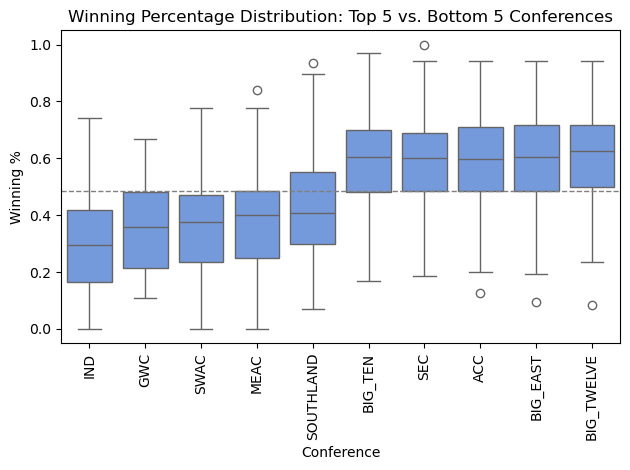

In [283]:
# Compute average winning percentage by conference
conf_means = (
    regular_season_stats.groupby('ConfAbbrev')['WinningPercentage']
    .mean()
    .sort_values()
)

# Get bottom 5 and top 5 conferences
n = 5
bottom_n = conf_means.head(n)
top_n = conf_means.tail(n)

# Combine for plotting
selected_confs = pd.concat([bottom_n, top_n])
conf_order = selected_confs.index

# Filter and plot
plt.figure()
sns.boxplot(
    data=regular_season_stats[regular_season_stats['ConfAbbrev'].isin(conf_order)],
    x='ConfAbbrev',
    y='WinningPercentage',
    order=conf_order,
    color='cornflowerblue'
)

plt.axhline(
    regular_season_stats.groupby('ConfAbbrev')['WinningPercentage'].mean().mean(),
    linestyle='--',
    color='gray',
    linewidth=1
)

plt.title("Winning Percentage Distribution: Top 5 vs. Bottom 5 Conferences")
plt.xlabel("Conference")
plt.ylabel("Winning %")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

The boxplot above illustrates the distribution of winning percentages for teams in the top 5 and bottom 5 conferences (based on historical average winning percentage). 

1. **Top 5 Conferences**:
    - The conferences with the highest average winning percentages are the Big Ten, SEC, ACC, Big East, and Big Twelve.
    - These conferences exhibit a higher median winning percentage, indicating a generally stronger performance across their teams.
    - The interquartile range (IQR) is relatively narrow, suggesting that the teams within these conferences have more consistent performance levels.

2. **Bottom 5 Conferences**:
    - The conferences with the lowest average winning percentages are the Independent (IND), Great West Conference (GWC), SWAC, MEAC, and Southland Conference.
    - These conferences show a lower median winning percentage, reflecting weaker overall team performance.
    - There is a higher degree of variability in team performance within these conferences.

***
## Advanced Metrics

- ELO
***

In [254]:
##################

In [255]:
##################

In [256]:
# # Final df - Save df to csv
# regular_season_stats.to_csv('./Data/Live/RegularSeasonStats.csv', index=False)